In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

DATA_DIR = "data"
BATCH_SIZE = 64

train_dataset = CIFAR10(root=DATA_DIR, train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
test_dataset = CIFAR10(root=DATA_DIR, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

image_shape = train_dataset[0][0].shape

print(f"Loaded batches of size {BATCH_SIZE}:")
print(f" - {len(train_dataloader)} batches for training ({num_train_images} images)")
print(f" - {len(test_dataloader)} batches for validation ({num_test_images} images)")
print(f"for a total of {num_train_images + num_test_images} images (Shape: {image_shape}).")

Loaded batches of size 64:
 - 781 batches for training (50000 images)
 - 157 batches for validation (10000 images)
for a total of 60000 images (Shape: torch.Size([3, 32, 32])).


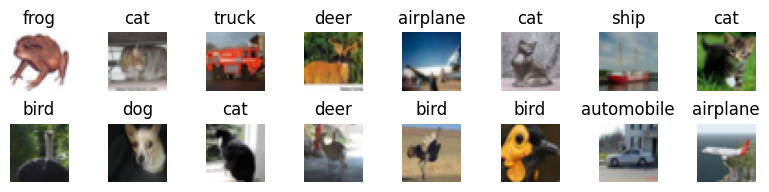

In [2]:
import matplotlib.pyplot as plt


def show_some_images(num_images, num_rows, dataloader, classes):
    num_cols = num_images // num_rows

    images, labels = next(iter(dataloader))
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_some_images(16, 2, train_dataloader, train_dataset.classes)

In [3]:
import torch
from unet import UNet
from vdm import VDM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Training Results Visualization

In [4]:
# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

from tqdm import tqdm
import torch.optim as optim

unet = UNet()
vdm = VDM(unet, image_shape=image_shape, device=device)
vdm = vdm.to(device)

optimizer = optim.AdamW(vdm.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99), weight_decay=0.01, eps=1e-8)

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}, Batches per epoch: {len(train_dataloader)}")

# Training loop
training_losses = []
training_bpds = []

validation_losses = []
validation_bpds = []

for epoch in range(NUM_EPOCHS):
    vdm.train()
    epoch_loss = 0.0
    epoch_bpd = 0.0

    for batch_idx, (images, _) in enumerate(pbar := tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()
        loss, bpd, bpd_components = vdm(images)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vdm.parameters(), 1.0)
        optimizer.step()

        # Track metrics
        epoch_loss += loss.item()
        epoch_bpd += bpd.item()

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{loss.item():.4f}",
                "bpd": f"{bpd.item():.4f}",
                "recon": f'{bpd_components["bpd_recon"]:.3f}',
                "kl": f'{bpd_components["bpd_klz"]:.3f}',
                "diff": f'{bpd_components["bpd_diff"]:.3f}',
            }
        )

    # Calculate epoch averages
    avg_loss = epoch_loss / len(train_dataloader)
    avg_bpd = epoch_bpd / len(train_dataloader)
    training_losses.append(avg_loss)
    training_bpds.append(avg_bpd)

    epoch_val_loss = 0.0
    epoch_val_bpd = 0.0

    vdm.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            images, _ = batch
            images = images.to(device)
            val_loss, val_bpd, _ = vdm(images)
            epoch_val_loss += val_loss.item()
            epoch_val_bpd += val_bpd.item()
    avg_val_loss = epoch_val_loss / len(test_dataloader)
    avg_val_bpd = epoch_val_bpd / len(test_dataloader)

    validation_losses.append(avg_val_loss)
    validation_bpds.append(avg_val_bpd)


    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, BPD: {avg_bpd:.4f}")

print("\nTraining completed!")

Starting training for 10 epochs...
Batch size: 64, Batches per epoch: 781


Epoch 1/10: 100%|██████████| 781/781 [05:59<00:00,  2.17it/s, loss=9525.5508, bpd=4.4735, recon=0.010, kl=0.001, diff=4.462] 


Epoch 1 - Loss: 12991.2560, BPD: 6.1010


Epoch 2/10: 100%|██████████| 781/781 [06:00<00:00,  2.17it/s, loss=9553.1895, bpd=4.4864, recon=0.010, kl=0.001, diff=4.475] 


Epoch 2 - Loss: 9638.4720, BPD: 4.5265


Epoch 3/10: 100%|██████████| 781/781 [06:05<00:00,  2.14it/s, loss=8878.1875, bpd=4.1694, recon=0.011, kl=0.001, diff=4.157]


Epoch 3 - Loss: 9153.5450, BPD: 4.2988


Epoch 4/10: 100%|██████████| 781/781 [06:02<00:00,  2.15it/s, loss=8951.4473, bpd=4.2038, recon=0.011, kl=0.001, diff=4.192]


Epoch 4 - Loss: 8912.4923, BPD: 4.1855


Epoch 5/10: 100%|██████████| 781/781 [05:55<00:00,  2.20it/s, loss=8678.5000, bpd=4.0757, recon=0.011, kl=0.001, diff=4.064]


Epoch 5 - Loss: 8775.6887, BPD: 4.1213


Epoch 6/10: 100%|██████████| 781/781 [05:55<00:00,  2.19it/s, loss=8453.8340, bpd=3.9702, recon=0.010, kl=0.001, diff=3.959]


Epoch 6 - Loss: 8652.3913, BPD: 4.0634


Epoch 7/10: 100%|██████████| 781/781 [05:57<00:00,  2.18it/s, loss=8051.1104, bpd=3.7810, recon=0.011, kl=0.001, diff=3.769]


Epoch 7 - Loss: 8325.2085, BPD: 3.9097


Epoch 8/10: 100%|██████████| 781/781 [05:56<00:00,  2.19it/s, loss=7762.2158, bpd=3.6453, recon=0.010, kl=0.001, diff=3.634]


Epoch 8 - Loss: 8003.9921, BPD: 3.7589


Epoch 9/10: 100%|██████████| 781/781 [05:56<00:00,  2.19it/s, loss=7799.5200, bpd=3.6629, recon=0.010, kl=0.001, diff=3.651]


Epoch 9 - Loss: 7843.2787, BPD: 3.6834


Epoch 10/10: 100%|██████████| 781/781 [06:06<00:00,  2.13it/s, loss=7615.5439, bpd=3.5765, recon=0.010, kl=0.001, diff=3.565]


Epoch 10 - Loss: 7757.5613, BPD: 3.6432

Training completed!


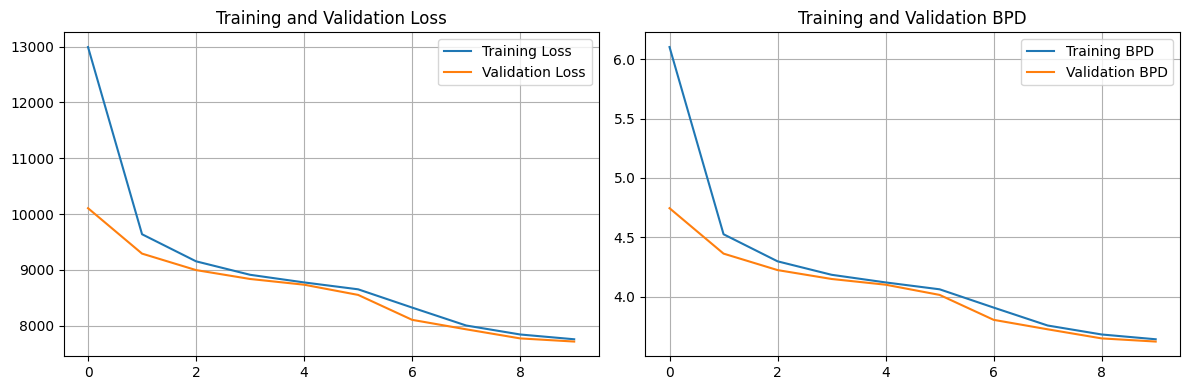

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_losses, label="Training Loss")
ax[0].plot(validation_losses, label="Validation Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(training_bpds, label="Training BPD")
ax[1].plot(validation_bpds, label="Validation BPD")
ax[1].set_title("Training and Validation BPD")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Generate Samples from Model

In [6]:
vdm.eval()

print("Generating samples from the model...")
print("This may take a few minutes...")

num_samples = 16
n_sample_steps = 1000

with torch.no_grad():
    samples = vdm.sample(batch_size=num_samples, n_sample_steps=n_sample_steps, clip_samples=True)
    samples = samples.cpu()

print(f"Generated {num_samples} samples with {n_sample_steps} denoising steps")

Generating samples from the model...
This may take a few minutes...


sampling: 100%|██████████| 1000/1000 [00:40<00:00, 24.97it/s]

Generated 16 samples with 1000 denoising steps


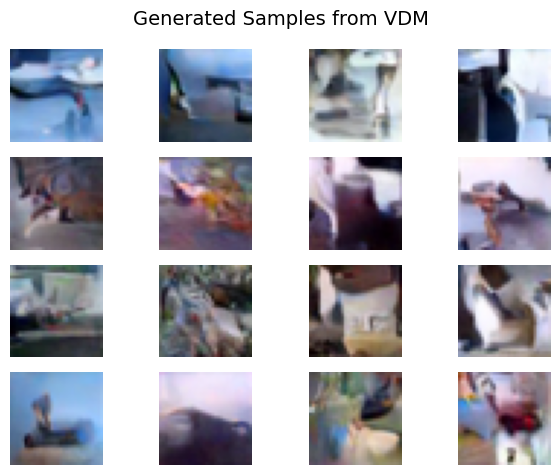

In [8]:
# Visualize generated samples
import numpy as np

fig, axes = plt.subplots(4, 4)
axes = axes.flatten()

for i in range(num_samples):
    img = samples[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    axes[i].imshow(img)
    axes[i].axis("off")

plt.suptitle("Generated Samples from VDM", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

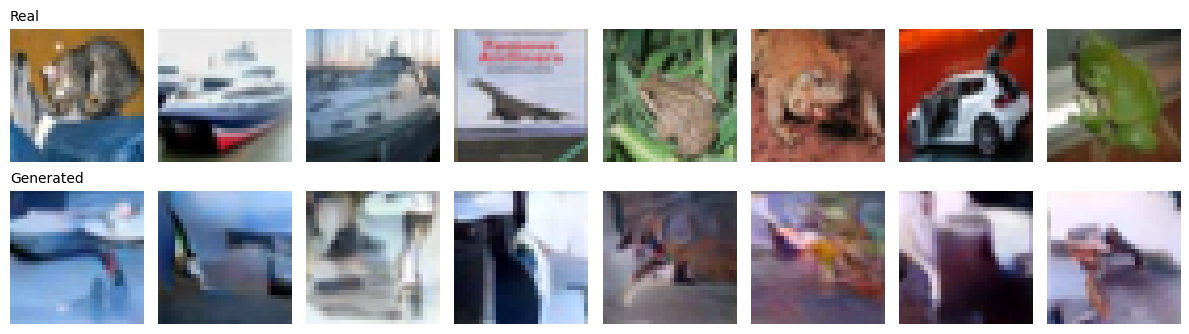

In [9]:
# Show real images alongside generated ones
fig, axes = plt.subplots(2, 8, figsize=(12, 3.5))

# Real images (top row)
real_images, real_labels = next(iter(test_dataloader))
for i in range(8):
    img = real_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Real", loc="left", fontsize=10)

# Generated images (bottom row)
for i in range(8):
    img = samples[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Generated", loc="left", fontsize=10)

plt.tight_layout()
plt.show()